In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.externals import joblib

In [38]:
Df = pd.read_excel("ArcFlash_Full_Data.xlsx",sheet_name = "Sheet1")
Df.shape

(32000, 28)

In [39]:
Column_Names = Df.columns
Column_Names

Index(['Bus Name', 'PD Name', 'Bus kV', 'Bus Bolted Fault (kA)',
       'Bus Arcing Fault (kA)', 'PD Bolted Fault (kA)', 'PD Arcing Fault (kA)',
       'Trip Time (sec)', 'Breaker time (sec)', 'Ground', 'Equip Type',
       'Busbar Config', 'Box Width (mm)', 'Box Height (mm)', 'Box Depth (mm)',
       'Gap (mm)', 'AF Boundary (mm)', 'Working Distance (mm)',
       'Incident Energy(cal/cm2)', 'PPE Level/Notes(*N)', 'Label #',
       'Cable length from trip device (m)', 'Incident Energy at Low Marginal',
       'Incident Energy at High Marginal', 'User Notes', 'User Notes2',
       'User Notes3', 'User Notes4'],
      dtype='object')

In [40]:
Columns_retained = ['Bus kV', 'Bus Bolted Fault (kA)', 'Bus Arcing Fault (kA)', 'Trip Time (sec)', 'Equip Type', 'Box Width (mm)', 'Box Height (mm)', 'Box Depth (mm)',
                    'Busbar Config', 'AF Boundary (mm)', 'Incident Energy(cal/cm2)']
Df_Columns_retained =  Df[Columns_retained]
Df_Columns_retained.shape

(32000, 11)

In [41]:
Columns_droped_Ecal = [ 'Box Width (mm)', 'Box Height (mm)', 'Box Depth (mm)','AF Boundary (mm)']

Df_Ecal = Df_Columns_retained.drop(columns=Columns_droped_Ecal)
Df_Ecal.shape

(32000, 7)

In [42]:
Df_Ecal = Df_Ecal.sample(frac=1).reset_index(drop=True)
Df_Ecal.head()

,Bus kV,Bus Bolted Fault (kA),Bus Arcing Fault (kA),Trip Time (sec),Equip Type,Busbar Config,Incident Energy(cal/cm2)
0,0.480000,34.97,24.87,1.55,PNL,VCB,94.317383
1,0.415000,37.29,23.38,0.80,SWG,VCB,31.460188
2,6.600000,42.51,37.81,0.90,PNL,VCBB,221.106857
3,3.300000,10.00,9.00,1.95,PNL,VCBB,96.867020
4,11.000001,47.51,43.62,0.20,PNL,VCBB,58.636951


In [43]:
Y = Df_Ecal['Incident Energy(cal/cm2)']
X = Df_Ecal.drop('Incident Energy(cal/cm2)', axis=1)

print( X.shape)
print( Y.shape)

(32000, 6)
(32000,)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1,stratify=X["Bus kV"])

In [45]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())])

numeric_features = ["Bus kV", "Bus Bolted Fault (kA)",'Bus Arcing Fault (kA)','Trip Time (sec)']
categorical_features = ["Equip Type", "Busbar Config"]


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


RandomForestRegressor results
Max positive error: 30.831811953709188
Max negative error: -22.98230580122642
Counts more than 5% error
268

GradientBoostingRegressor results
Max positive error: 16.228344237949056
Max negative error: -17.608692956242354
Counts more than 5% error
62


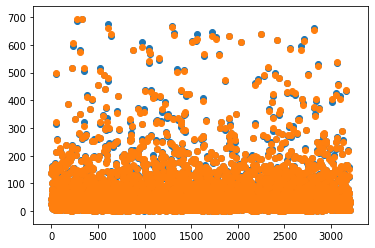

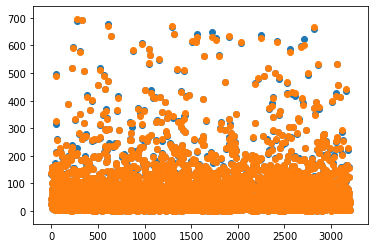

In [48]:
def Run_models_ensemble(model_var,X_train,Y_train,X_test,Y_test,Error_to_Observe = 5):
    
    model_var.fit(X_train, Y_train)

    Y_predict = model_var.predict(X_test)
    
    print("\n{} results".format(type(model_var).__name__))

    Df_Ecal_result = pd.DataFrame({"Prediction": Y_predict, "Test":Y_test})
    Df_Ecal_result["% error"] = (Df_Ecal_result["Prediction"]/Df_Ecal_result["Test"]  - 1)*100
    Df_Ecal_result.to_excel("result_Ecal_"+str(type(model_var).__name__)+ ".xlsx")
    print('Max positive error:', Df_Ecal_result["% error"].max())
    print('Max negative error:',Df_Ecal_result["% error"].min())
    plt.figure()
    plt.scatter(range(len(Y_test)),Y_test)
    plt.scatter(range(len(Y_test)),Y_predict)
    print('Counts more than {}% error'.format(Error_to_Observe))
    print(Df_Ecal_result[(Df_Ecal_result["% error"] > Error_to_Observe) | (Df_Ecal_result["% error"] <= -Error_to_Observe)].count()["% error"])
    joblib.dump(model_var, str(type(model_var).__name__) + ".pkl")
    
forest_reg1 = RandomForestRegressor(n_estimators= 200, bootstrap = True, max_depth= 30,max_features= 'auto', random_state=42)
GBR_reg1 = GradientBoostingRegressor(n_estimators= 100,  max_depth= 10,max_features= None, random_state=42,warm_start=True, tol=0.0001,loss='huber')


Run_models_ensemble(forest_reg1,X_train_prep,Y_train,X_test_prep,Y_test,5)
Run_models_ensemble(GBR_reg1,X_train_prep,Y_train,X_test_prep,Y_test,5)

In [ ]:
DF_Final_Test = pd.read_excel("ArcFlash_Final_test_data.xls",skiprows=4,skipfooter=4,header= None)
Columns_retained = ['Bus kV', 'Bus Bolted Fault (kA)', 'Bus Arcing Fault (kA)', 'Trip Time (sec)', 'Equip Type','Busbar Config','Incident Energy(cal/cm2)']
DF_Final_Test = DF_Final_Test[[2,3,4,7,10,11,18]]
DF_Final_Test.columns = Columns_retained
DF_Final_Test.head()

In [ ]:
Y_Final_To_Predict_DF = DF_Final_Test['Incident Energy(cal/cm2)']
X_Final_Predict_DF = DF_Final_Test.drop('Incident Energy(cal/cm2)', axis=1)

X_predict = preprocessor.transform(X_Final_Predict_DF)
X_Final_Predict_DF

In [ ]:
joblib_model = joblib.load('RandomForestRegressor.pkl')
Ypredict_rf = joblib_model.predict(X_predict)
Ypredict_rf

In [ ]:
joblib_model = joblib.load('GradientBoostingRegressor.pkl')
Ypredict_gbr = joblib_model.predict(X_predict)
Ypredict_gbr

In [ ]:
Y_Final_To_Predict_DF

In [ ]:
(Ypredict_rf - Y_Final_To_Predict_DF)/Y_Final_To_Predict_DF*100

In [ ]:
(Ypredict_gbr - Y_Final_To_Predict_DF)/Y_Final_To_Predict_DF*100